# TRAINING AN IMAGE CLASSIFIER
flowers is a dataset with 8189 images of different sizes and 102 labels.
We will do the following:

1) **Load** and **normalize** the flowers training and test dataset *
2) **Define** a **Convolutional Neural Network (CNN)**
3) **Define** a **loss function** 
4) **Train** the network on training data
5) **Test** the network on test data

In [142]:
import torch
import torchvision
import torchvision.transforms as transforms
import scipy.io
import os

In [143]:
#LOAD DATA

labels = scipy.io.loadmat('imagelabels.mat')['labels'].squeeze() #squeeze toglie assi extra da (N,1) a (N,) ad es.
splits = scipy.io.loadmat('setid.mat')

#labels = array con numeri da 1 a 102 per ogni sample (8189)
#splits =  campi tstid e trnid con gli id dei sample per test e train set

train_ids = splits['trnid'].squeeze() -1 #matlab conta da 1
test_ids = splits['tstid'].squeeze() -1 #matlab conta da 1

In [144]:
#define custom dataset
from torch.utils.data import Dataset
from PIL import Image #image CON VALORI DA 0 A 255 che con ToTensor diventano da 0 a 1 e con Normalize diventano da -1 a 1
import torchvision.transforms as transforms

class FlowersDataset(Dataset):
    def __init__(self, indices, labels, images_dir, transform=None):
        self.indices = indices
        self.labels = labels
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, index):
        image_idx = self.indices[index]
        label = self.labels[image_idx] - 1 #labels va da 1 a 102
        path = os.path.join(self.images_dir, f'image_{image_idx+1:05d}.jpg')
        image = Image.open(path).convert('RGB') #return PILImage
        if self.transform:
            image = self.transform(image)
        return image, label
    

In [145]:
#define dataloader

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = FlowersDataset(indices=train_ids, labels=labels, images_dir='./102flowers/jpg', transform=transform_train)
testset = FlowersDataset(indices=test_ids, labels=labels, images_dir='./102flowers/jpg', transform=transform_test)

batch_size = 16
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

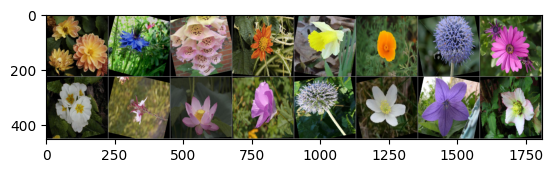

59	32	93	58	41	64	9	65	52	56	77	54	9	68	18	39	


In [146]:
#visualize some images

import matplotlib.pyplot as plt
import numpy as np

def imshow(image):
    image = image.detach().cpu()               # togli grad e porta su CPU
    image = (image + 1)/2
    npimage = image.numpy()
    npimage = np.transpose(npimage, (1, 2, 0))
    plt.imshow(npimage)
    plt.show()

dataiter = iter(train_loader)
images, targets = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(''.join(f'{targets[i]}\t' for i in range(batch_size)))

# DEFINE CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 21, padding=10)
        self.pool = nn.MaxPool2d(2, stride=2) #halfening
        self.conv2 = nn.Conv2d(6, 12, 21, padding=10)
        #!remember pool
        self.fc1 = nn.Linear(56*56*12, 1000)
        self.fc2 = nn.Linear(1000, 800)
        self.fc3 = nn.Linear(800, 600)
        self.fc4 = nn.Linear(600, 400)
        self.fc5 = nn.Linear(400, 102)
    
    def forward(self, images):
        x = self.pool(F.relu(self.conv1(images)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x
net = CNN()

# Define Loss and Optimizer

In [148]:
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train net

In [149]:
epochs = 30
model = net.cuda()

for epoch in range(epochs):
    tot_loss, tot_samples = 0.0, 0
    for i, batch in enumerate(train_loader):
        images, targets = batch
        images, targets = images.cuda(), targets.cuda()

        tot_samples +=images.size(0)

        optimizer.zero_grad()

        preds = model(images)
        
        loss = criterion(preds, targets)

        loss.backward()

        optimizer.step()

        tot_loss += loss.item() * images.size(0)

        if i%50==49:
            print(f'Average loss for epoch {epoch+1} batch {i+1}: {1.0*tot_loss/float(tot_samples):.6f}')
print('Training finished')

Average loss for epoch 1 batch 50: 4.625400
Average loss for epoch 2 batch 50: 4.625312
Average loss for epoch 3 batch 50: 4.624721
Average loss for epoch 4 batch 50: 4.624802
Average loss for epoch 5 batch 50: 4.623332
Average loss for epoch 6 batch 50: 4.622699
Average loss for epoch 7 batch 50: 4.621733
Average loss for epoch 8 batch 50: 4.619324
Average loss for epoch 9 batch 50: 4.605551
Average loss for epoch 10 batch 50: 4.539032
Average loss for epoch 11 batch 50: 4.384300
Average loss for epoch 12 batch 50: 4.259857
Average loss for epoch 13 batch 50: 4.122587
Average loss for epoch 14 batch 50: 3.973372
Average loss for epoch 15 batch 50: 3.798542
Average loss for epoch 16 batch 50: 3.748551
Average loss for epoch 17 batch 50: 3.612272
Average loss for epoch 18 batch 50: 3.504103
Average loss for epoch 19 batch 50: 3.400410
Average loss for epoch 20 batch 50: 3.309298
Average loss for epoch 21 batch 50: 3.270011
Average loss for epoch 22 batch 50: 3.179337
Average loss for ep

# SAVE RESULTS


In [150]:
PATH = './model.pth'

torch.save(model.state_dict(), PATH)

#conv1.weights, fc1.bias ecc...

#!caricare
#load = torch.load('saves.pth') 
#CNN.load_state_dict(load) 

# TEST CNN

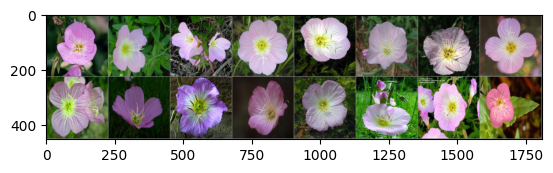

tensor([False, False, False,  True, False, False, False,  True, False, False,
        False, False, False, False, False, False], device='cuda:0')	


In [152]:
#little sample with images

dataiter = iter(test_loader)
images, targets = next(dataiter)

#show images
imshow(torchvision.utils.make_grid(images))
images, targets = images.cuda(), targets.cuda()

outputs = model(images)
_, predicted = torch.max(outputs, 1)
print(''.join(f'{predicted==targets}\t'))

In [151]:
#all testset
correct_pred = {classname:0 for classname in range(102)}
total_pred = {classname:0 for classname in range(102)}

corrects = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        images, targets = batch
        images, targets = images.cuda(), targets.cuda()

        total += images.size(0)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1) 

        for (label, pred) in zip(targets, predicted):
            total_pred[label.item()] += 1
            if (label == pred):
                correct_pred[label.item()] += 1
                corrects +=1

print(f'Total accuracy: {100*(1.0*corrects/float(total)):.2f}%') 

for classname in correct_pred.keys():
    print(f'Accuracy for class {classname}: {100*(1.0*correct_pred[classname]/float(total_pred[classname])):.2f}%') 


Total accuracy: 12.72%
Accuracy for class 0: 10.00%
Accuracy for class 1: 12.50%
Accuracy for class 2: 15.00%
Accuracy for class 3: 8.33%
Accuracy for class 4: 8.89%
Accuracy for class 5: 12.00%
Accuracy for class 6: 5.00%
Accuracy for class 7: 27.69%
Accuracy for class 8: 3.85%
Accuracy for class 9: 0.00%
Accuracy for class 10: 1.49%
Accuracy for class 11: 34.33%
Accuracy for class 12: 17.24%
Accuracy for class 13: 7.14%
Accuracy for class 14: 20.69%
Accuracy for class 15: 4.76%
Accuracy for class 16: 41.54%
Accuracy for class 17: 9.68%
Accuracy for class 18: 0.00%
Accuracy for class 19: 33.33%
Accuracy for class 20: 0.00%
Accuracy for class 21: 7.69%
Accuracy for class 22: 21.13%
Accuracy for class 23: 27.27%
Accuracy for class 24: 0.00%
Accuracy for class 25: 23.81%
Accuracy for class 26: 40.00%
Accuracy for class 27: 4.35%
Accuracy for class 28: 0.00%
Accuracy for class 29: 18.46%
Accuracy for class 30: 0.00%
Accuracy for class 31: 0.00%
Accuracy for class 32: 0.00%
Accuracy for cl